# Jetsoncar Rosey V2

Tensorflow 2.0, all in notebook, optimized with RT

In [4]:
import tensorflow as tf
print(tf.__version__)
tf.config.experimental.list_physical_devices('GPU') # If device does not show and using conda env with tensorflow-gpu then try restarting computer

2.0.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

(480, 848, 3)


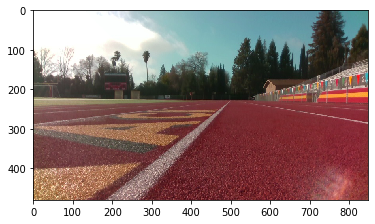

In [5]:
# verify the image data directory
import os
data_directory = "/media/michael/BigMemory/datasets/jetsoncar/backup1-12-20/data/dataset"
os.listdir(data_directory)[:10]

import matplotlib.pyplot as plt
img = plt.imread(os.path.join(data_directory + "/color_images", os.listdir(data_directory + "/color_images")[0]))
print(img.shape)
plt.imshow(img)

## Create the datagenerator and augmentation framework

(240, 640, 3)
(480, 848, 3)
(1, 240, 640, 3)


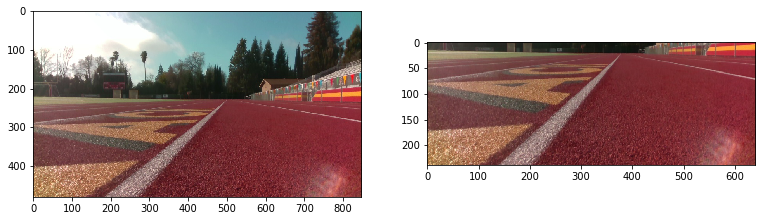

In [6]:
# Include the custom utils.py and perform tests
import importlib
utils = importlib.import_module('utils')
import numpy as np

print(utils.INPUT_SHAPE)

img = utils.load_image(os.path.join(data_directory, 'color_images'),os.listdir(data_directory + "/color_images")[0])
print(img.shape)

fig = plt.figure(figsize=(20,20))
fig.add_subplot(1, 3, 1)
plt.imshow(img)

img, _ = utils.preprocess_data(last_color_image=img)
print(img.shape)

fig.add_subplot(1, 3, 2)
plt.imshow(np.squeeze(img))

plt.show()

Number of data samples is 9364


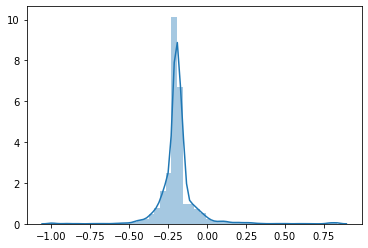

In [31]:
# Load the steering angles and image paths from labels.csv
import csv, random
import seaborn as sns

# these will be 2D arrays where each row represents a dataset
x = [] # images
y = [] # steering
z = [] # speed
with open(os.path.join(data_directory, "tags.csv")) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # print(row['Time_stamp'] + ".jpg", row['Steering_angle'])
        if not float(row['raw_speed']) == 0:
            x.append(row['time_stamp'] + ".jpg",)  # get image path
            y.append(float(row['raw_steering']),) # get steering value
            z.append(float(row['raw_speed']))

print("Number of data samples is " + str(len(y)))

data = list(zip(x,y))
random.shuffle(data)
x,y = zip(*data)

# plot of steering angle distribution without correction
sns.distplot(y)

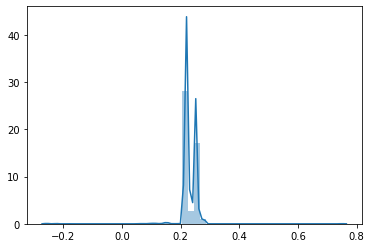

In [34]:
# plot of speed distribution
sns.distplot(z)

In [8]:
# Split the training data
validation_split = 0.2
train_x = x[0:int(len(x)*(1.0-validation_split))]
train_y = y[0:int(len(y)*(1.0-validation_split))]
print("Training data shape: " + str(len(train_x)))
test_x = x[int(len(x)*(1.0-validation_split)):]
test_y = y[int(len(y)*(1.0-validation_split)):]
print("Validation data shape: " + str(len(test_x)) + "\n")

Training data shape: 7807
Validation data shape: 1952



(32, 240, 640, 3)
-0.10050076364334565


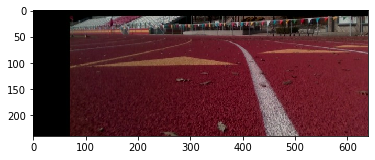

In [58]:
# Define and test batch generator
def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, utils.IMAGE_HEIGHT, utils.IMAGE_WIDTH, utils.IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(len(image_paths)):
            img = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.8:
                image, steering_angle = utils.augument(data_dir, os.path.join("color_images",img), steering_angle)
            else:
                image, _ = utils.preprocess_data(utils.load_image(data_dir, os.path.join("color_images",img)))
            # add the image and steering angle to the batch
            images[i] = image
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers
        
train_generator = batch_generator(data_directory, train_x, train_y, 32, True)
validation_generator = batch_generator(data_directory, test_x, test_y, 32, False)

train_image = next(train_generator) # returns tuple with steering and throttle
print(train_image[0].shape)
print(train_image[1][0])
plt.imshow(train_image[0][0])

## Define the model and start training

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.Input((utils.IMAGE_HEIGHT, utils.IMAGE_WIDTH, utils.IMAGE_CHANNELS)),
    tf.keras.layers.Conv2D(32, (11,11), padding='same', kernel_initializer='lecun_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Conv2D(32, (7,7), padding='same', kernel_initializer='lecun_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Conv2D(64, (5,5), padding='same', kernel_initializer='lecun_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer='lecun_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer='lecun_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,3)),
    
    tf.keras.layers.Conv2D(16, (3,3), padding='same', kernel_initializer='lecun_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPool2D((2,3)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')
])
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 640, 32)      11648     
_________________________________________________________________
batch_normalization (BatchNo (None, 240, 640, 32)      128       
_________________________________________________________________
elu (ELU)                    (None, 240, 640, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 320, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 320, 32)      50208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 320, 32)      128       
_________________________________________________________________
elu_1 (ELU)                  (None, 120, 320, 32)      0

In [8]:
import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
print("To view tensorboard please run `tensorboard --logdir logs/fit` in the code directory from the terminal with deeplearning env active")

checkpoint = tf.keras.callbacks.ModelCheckpoint('rosey_v2.{epoch:03d}-{val_loss:.2f}.h5', # filepath = working directory/
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

model.fit_generator(train_generator,
                    steps_per_epoch=100, 
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=1,
                   callbacks=[tensorboard_callback, checkpoint])

To view tensorboard please run `tensorboard --logdir logs/fit` in the code directory from the terminal with deeplearning env active
Epoch 1/20
100/100 [==============================] - 124s 1s/step - loss: 0.1668 - val_loss: 0.1751
Epoch 2/20
100/100 [==============================] - 121s 1s/step - loss: 0.0667 - val_loss: 0.0703
Epoch 3/20
100/100 [==============================] - 121s 1s/step - loss: 0.0546 - val_loss: 0.0255
Epoch 4/20
100/100 [==============================] - 121s 1s/step - loss: 0.0561 - val_loss: 0.0161
Epoch 5/20
100/100 [==============================] - 121s 1s/step - loss: 0.0491 - val_loss: 0.0189
Epoch 6/20
100/100 [==============================] - 121s 1s/step - loss: 0.0560 - val_loss: 0.0479
Epoch 7/20
100/100 [==============================] - 121s 1s/step - loss: 0.0515 - val_loss: 0.0175
Epoch 8/20
100/100 [==============================] - 121s 1s/step - loss: 0.0458 - val_loss: 0.0411
Epoch 9/20
100/100 [==============================] - 122s 1

In [10]:
# Test the model
image, steering = next(train_generator)
print(steering)
print(model.predict(image))
print("")

image, steering = next(validation_generator)
print(steering)
print(model.predict(image))

[ 0.43421115 -0.20259999 -0.14242884 -0.44916121 -0.22559999 -0.47990076
 -0.33123732 -0.1636     -0.2006     -0.0924799   0.0577482  -0.29629822
 -0.25059998 -0.2531061  -0.11630341 -0.20200001 -0.20259999 -0.33663206
 -0.31759998  0.23706487 -0.26719999  0.11677072  0.39489792  0.21049982
 -0.39819626 -0.1636     -0.1736      0.04663537  0.06085892 -0.06823618
 -0.1636      0.20842234]
[[ 0.1979373 ]
 [-0.25673136]
 [ 0.02869774]
 [-0.04835044]
 [-0.16725713]
 [-0.10261327]
 [ 0.04136334]
 [-0.20059396]
 [-0.26783448]
 [-0.10717426]
 [ 0.09875257]
 [ 0.03318416]
 [-0.336002  ]
 [-0.06220468]
 [-0.05580045]
 [-0.10747512]
 [-0.21253927]
 [-0.16874841]
 [-0.21268037]
 [ 0.12241864]
 [-0.25121132]
 [ 0.05909761]
 [-0.08007676]
 [ 0.06073587]
 [-0.12815633]
 [-0.06831729]
 [-0.13042186]
 [ 0.10264973]
 [-0.21015042]
 [-0.09192888]
 [-0.17632425]
 [ 0.16250354]]

[-0.20259999 -0.1636     -0.2032     -0.19180001 -0.2712     -0.4206
 -0.1636     -0.2006     -0.1636     -0.20259999 -0.358000

## Save the model as tensor RT and export to Jetson format

In [72]:
# Load the model that you would like converted to RT
model_path = 'model.h5'
export_path = "/home/michael/Desktop/model"

if not os.path.isdir(export_path):
    os.mkdir(export_path)
else:
    response = input("Do you want to delete existing export_path directory? y/n")
    if response == 'y':
        shutil.rmtree(export_path)
        os.mkdir(export_path)

loaded_model = tf.keras.models.load_model(model_path)

import shutil
shutil.copy("./utils.py", os.path.join(export_path, "utils.py"))
shutil.copy("./notes.txt", os.path.join(export_path, "notes.txt"))
shutil.copy("./config.yaml", os.path.join(export_path, "config.yaml"))
# Save as tf saved_model (faster than h5)
tf.saved_model.save(loaded_model, export_path)

Do you want to delete existing export_path directory? y/n y


INFO:tensorflow:Assets written to: /home/michael/Desktop/model/assets


In [73]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS
conversion_params = conversion_params._replace(max_workspace_size_bytes=(1 << 32))
conversion_params = conversion_params._replace(precision_mode="INT8")
conversion_params = conversion_params._replace(maximum_cached_engines=100)
conversion_params = conversion_params._replace(use_calibration=True)

def my_calibration_input_fn():
    for i in range(20):
        image, _ = utils.preprocess_data(utils.load_image(data_directory, os.path.join("color_images",x[i])))
        yield image.astype(np.float32),

converter = trt.TrtGraphConverterV2(input_saved_model_dir=export_path,conversion_params=conversion_params)

gen = my_calibration_input_fn()

converter.convert(calibration_input_fn=my_calibration_input_fn)

if not os.path.isdir(os.path.join(export_path, "rt")):
    os.mkdir(os.path.join(export_path, "rt"))
    
converter.save(os.path.join(export_path, "rt"))

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Running against TensorRT version 0.0.0
INFO:tensorflow:Assets written to: /home/michael/Desktop/model/rt/assets


In [70]:
# Test normal saved model
saved_model = tf.saved_model.load(export_path) # normal saved model

image, _ = next(validation_generator)

import time
output = saved_model(image.astype(np.float32)) # load once to get more accurate representation of speed
start = time.time()
output = saved_model(image.astype(np.float32))
stop = time.time()
print("inference time: " + str(stop - start))
print("Output: %.20f"%output[8,0])

inference time: 0.062093496322631836
Output: -0.25761821866035461426


In [69]:
# Test TRT optimized saved model
saved_model = tf.saved_model.load(os.path.join(export_path, "rt")) # normal saved model

image, _ = next(validation_generator)

import time
output = saved_model(image.astype(np.float32)) # load once to get more accurate representation of speed
start = time.time()
output = saved_model(image.astype(np.float32))
stop = time.time()
print("inference time: " + str(stop - start))
print("Output: %.20f"%output[8,0])

inference time: 0.06771111488342285
Output: 0.29770836234092712402
